In [1]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
import shap
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pymoo.factory import get_performance_indicator
from optuna.exceptions import TrialPruned
import miceforest as mf
from autocluster.autohypothesis import autohypothesis_utils

In [2]:
emploi_df_old = pd.read_csv('emploi.csv').drop(columns=["brsa_clep"])
#emploi_df_old = pd.read_csv('emploi.csv').drop(columns=["brsa_clep","age","duree_inscription_pe","dernier_contact_pe"])
emploi_df_old.rename(columns={"duree_rsa_annee": "target"}, inplace=True)

In [3]:
df =emploi_df_old

In [4]:
category_mappings = {}

for column in df.columns:
    if df[column].dtype == 'object':
        # Convertir la colonne en type 'category' et enregistrer le mappage
        df[column] = df[column].astype('category')
        # Enregistre le mappage de la catégorie vers le code
        category_mappings[column] = dict(enumerate(df[column].cat.categories))
        # Encodage des catégories en entiers
        df[column] = df[column].cat.codes.replace(-1, np.nan)




In [5]:

# Create kernel. 
kds = mf.ImputationKernel(
  df,
  save_all_iterations=True,
  random_state=100
)

# Run the MICE algorithm for 2 iterations
kds.mice(10)

# Return the completed dataset.
df_imputed = kds.complete_data()



In [6]:

for column in df_imputed.columns:
    if column in category_mappings:
        df_imputed[column] = df_imputed[column].map(category_mappings[column])

df_imputed

,brsa_sexe,age,brsa_role_foyer,brsa_nb_enfant_aut_charge,brsa_etat_dossier,target,situation_familliale,diag_formation_initiale,diag_frein_logement,diag_logement,diag_vie_famille,pe_libelle_niveau_formation,dernier_contact_pe,duree_inscription_pe,pe_inscription,pe_axe_travail_principal,pe_categorie_inscription,pe_modalite_accompagnement
0,Homme,17,CJT,2,Droits ouvert et versable,1,En concubinage,niveau V bis (préqualification),Non,J'ai un logement,Non concerné,AUCUNE FORMATION SCOLAIRE,80.0,296.0,Non,Adaptation au marché du travail,"Catégorie 1\nPersonnes sans emploi, immédiatem...",GUI - accompagnement guidé
1,Femme,17,DEM,0,Droits ouvert et versable,0,Célibataire,"niveau IV (BP, BT, baccalauréat professionnel ...",Non,Je suis hébergé(e) (plusieurs choix possible),Oui,BEPC / 3EME ACHEVEE,668.0,382.0,Non,Élaboration du projet professionnel,"Catégorie 4\nPersonnes sans emploi, non immédi...",REN - accompagnement renforcé
2,Femme,18,DEM,2,Droits ouvert et versable,1,En concubinage,niveau V bis (préqualification),Non,J'ai un logement,Non,AUCUNE FORMATION SCOLAIRE,175.0,379.0,Non,Levée des freins périphériques à l'emploi,"Catégorie 3\nPersonnes sans emploi, immédiatem...",REN - accompagnement renforcé
3,Femme,18,DEM,1,Droits ouvert et versable,1,Isolement après vie maritale ou Pacs,niveau V bis (préqualification),Non,J'ai un logement,Non,AUCUNE FORMATION SCOLAIRE,227.0,365.0,Non,Strategie de recherche d'emploi,"Catégorie 2\nPersonnes sans emploi, immédiatem...",REN - accompagnement renforcé
4,Femme,18,DEM,1,Droits ouvert et versable,1,Célibataire,"niveau V (CAP, BEP, CFPA du premier degré)",Non,Je suis hébergé(e) (plusieurs choix possible),Non,"CERTIFICATION DE NIVEAU 5 (CAP, BEP)",224.0,149.0,Oui,Adaptation au marché du travail,"Catégorie 1\nPersonnes sans emploi, immédiatem...",GUI - accompagnement guidé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,Femme,68,DEM,0,Droits ouvert et versable,0,Veuvage,"niveau V (CAP, BEP, CFPA du premier degré)",Non,Je suis hébergé(e) (plusieurs choix possible),Non,BEPC / 3EME ACHEVEE,891.0,484.0,Non,Strategie de recherche d'emploi,"Catégorie 3\nPersonnes sans emploi, immédiatem...",GUI - accompagnement guidé
6312,Homme,68,DEM,0,Droits ouvert et versable,0,Célibataire,sans niveau spécifique,Non,J'ai un logement,Non,CERTIFICATION DE NIVEAU 3 (BAC + 2),702.0,1248.0,Non,Levée des freins périphériques à l'emploi,"Catégorie 1\nPersonnes sans emploi, immédiatem...",GUI - accompagnement guidé
6313,Femme,69,DEM,0,Droits ouvert et versable,0,Veuvage,"niveau IV (BP, BT, baccalauréat professionnel ...",Non,Je recherche actuellement une solution de loge...,Non,"CERTIFICATION DE NIVEAU 5 (CAP, BEP)",1703.0,480.0,Non,Techniques de recherche d'emploi,"Catégorie 1\nPersonnes sans emploi, immédiatem...",GUI - accompagnement guidé
6314,Femme,76,DEM,0,Droits ouvert et versable,0,Veuvage,information non communiquée,Non,Je suis hébergé(e) (plusieurs choix possible),Non,BEPC / 3EME ACHEVEE,1190.0,994.0,Non,Élaboration du projet professionnel,"Catégorie 2\nPersonnes sans emploi, immédiatem...",GUI - accompagnement guidé


In [7]:

non_ordinal_columns = [column for column in df_imputed.columns if df_imputed[column].dtype == 'object']

# Applique le one-hot encoding seulement aux colonnes non ordinales
df_imputed = pd.get_dummies(df_imputed, columns=non_ordinal_columns, drop_first=True)


In [8]:
df_imputed

,age,brsa_nb_enfant_aut_charge,target,dernier_contact_pe,duree_inscription_pe,brsa_sexe_Homme,brsa_role_foyer_DEM,brsa_etat_dossier_Droits clos,brsa_etat_dossier_Droits clos et ayant eu un contrôle,brsa_etat_dossier_Droits ouvert et suspendu,...,"pe_categorie_inscription_Catégorie 5\nPersonnes sans emploi, non immédiatement disponibles, à la recherche dun emploi.",pe_modalite_accompagnement_ACO -,pe_modalite_accompagnement_ACT -,pe_modalite_accompagnement_APP -,pe_modalite_accompagnement_ENT -,pe_modalite_accompagnement_GLO - accompagnement global,pe_modalite_accompagnement_GUI - accompagnement guidé,pe_modalite_accompagnement_MVE -,pe_modalite_accompagnement_REN - accompagnement renforcé,pe_modalite_accompagnement_SUI - suivi
0,17,2,1,80.0,296.0,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,17,0,0,668.0,382.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,18,2,1,175.0,379.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,18,1,1,227.0,365.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,18,1,1,224.0,149.0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,68,0,0,891.0,484.0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6312,68,0,0,702.0,1248.0,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6313,69,0,0,1703.0,480.0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6314,76,0,0,1190.0,994.0,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [9]:
import pandas as pd
import numpy as np

# Initialisation de la liste pour stocker les résultats
results = []

# Nombre de runs
n_runs = 1  # Définissez n selon votre besoin

for run in range(n_runs):
    # Exécutez le code original
    #exp, X_train, X_dev, y_train, y_dev = opti_loop(iris, 200, norm="minmax", optimize_obj="solo")
    exp, X_train, X_dev, y_train, y_dev = autohypothesis_utils.opti_loop(df_imputed, 500,  optimize_obj="solo")
    all_objectives = np.array([trial.values for trial in exp.best_trials])
    sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
    params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=exp.best_trials[0].number)
    pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
    pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_dev, pipeline.predict(X_dev))
    entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
    
    # Stockage des résultats pour cette itération
    results.append({
        "run_number": run + 1,
        "accuracy": acc,
        "entropy": 1 - entropy,
        "params": exp.best_trials[0].params
    })

# Création du DataFrame pour toutes les runs
df_runs = pd.DataFrame(results)

# Calcul de la moyenne des accuracies et entropies
avg_accuracy = np.mean(df_runs["accuracy"])
avg_entropy = np.mean(df_runs["entropy"])

# Création du DataFrame pour les moyennes
df_avg = pd.DataFrame([{
    "avg_accuracy": avg_accuracy,
    "avg_entropy": avg_entropy
}])

print(df_runs)
print(df_avg)


[I 2024-04-25 14:01:17,873] A new study created in memory with name: no-name-e9fb6148-a938-4e53-a3da-47dfd09fbd58


[I 2024-04-25 14:01:19,757] Trial 0 finished with value: 0.49973614775725594 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 880, 'rf_max_depth': 7, 'rf_min_samples_split': 0.7454631398018521, 'rf_min_samples_leaf': 0.2797052411480127, 'rf_max_features': 'log2', 'rf_random_state': 42}. Best is trial 0 with value: 0.49973614775725594.
[I 2024-04-25 14:01:20,777] Trial 1 finished with value: 0.49973614775725594 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 460, 'rf_max_depth': 23, 'rf_min_samples_split': 0.21889707087717658, 'rf_min_samples_leaf': 0.32747131878542446, 'rf_max_features': 'log2', 'rf_random_state': 42}. Best is trial 0 with value: 0.49973614775725594.
[I 2024-04-25 14:01:21,951] Trial 2 finished with value: 0.7160949868073878 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 400, 'rf_max_depth': 26, 'rf_min_samples_split': 0.43369517044658995, 'rf_min_samples_leaf': 0.04923472626573292, 'rf_max_features': 'sqrt', 'rf_ra

   run_number  accuracy   entropy  \
0           1  0.740897  0.659242   

                                              params  
0  {'classifier': 'RandomForest', 'rf_n_estimator...  
   avg_accuracy  avg_entropy
0      0.740897     0.659242


In [10]:
entropy

0.3407575336702283

In [11]:
df_runs.to_csv("runs_solo_rsa_old_500.csv")
df_avg.to_csv("avg_solo_rsa_old_500.csv")

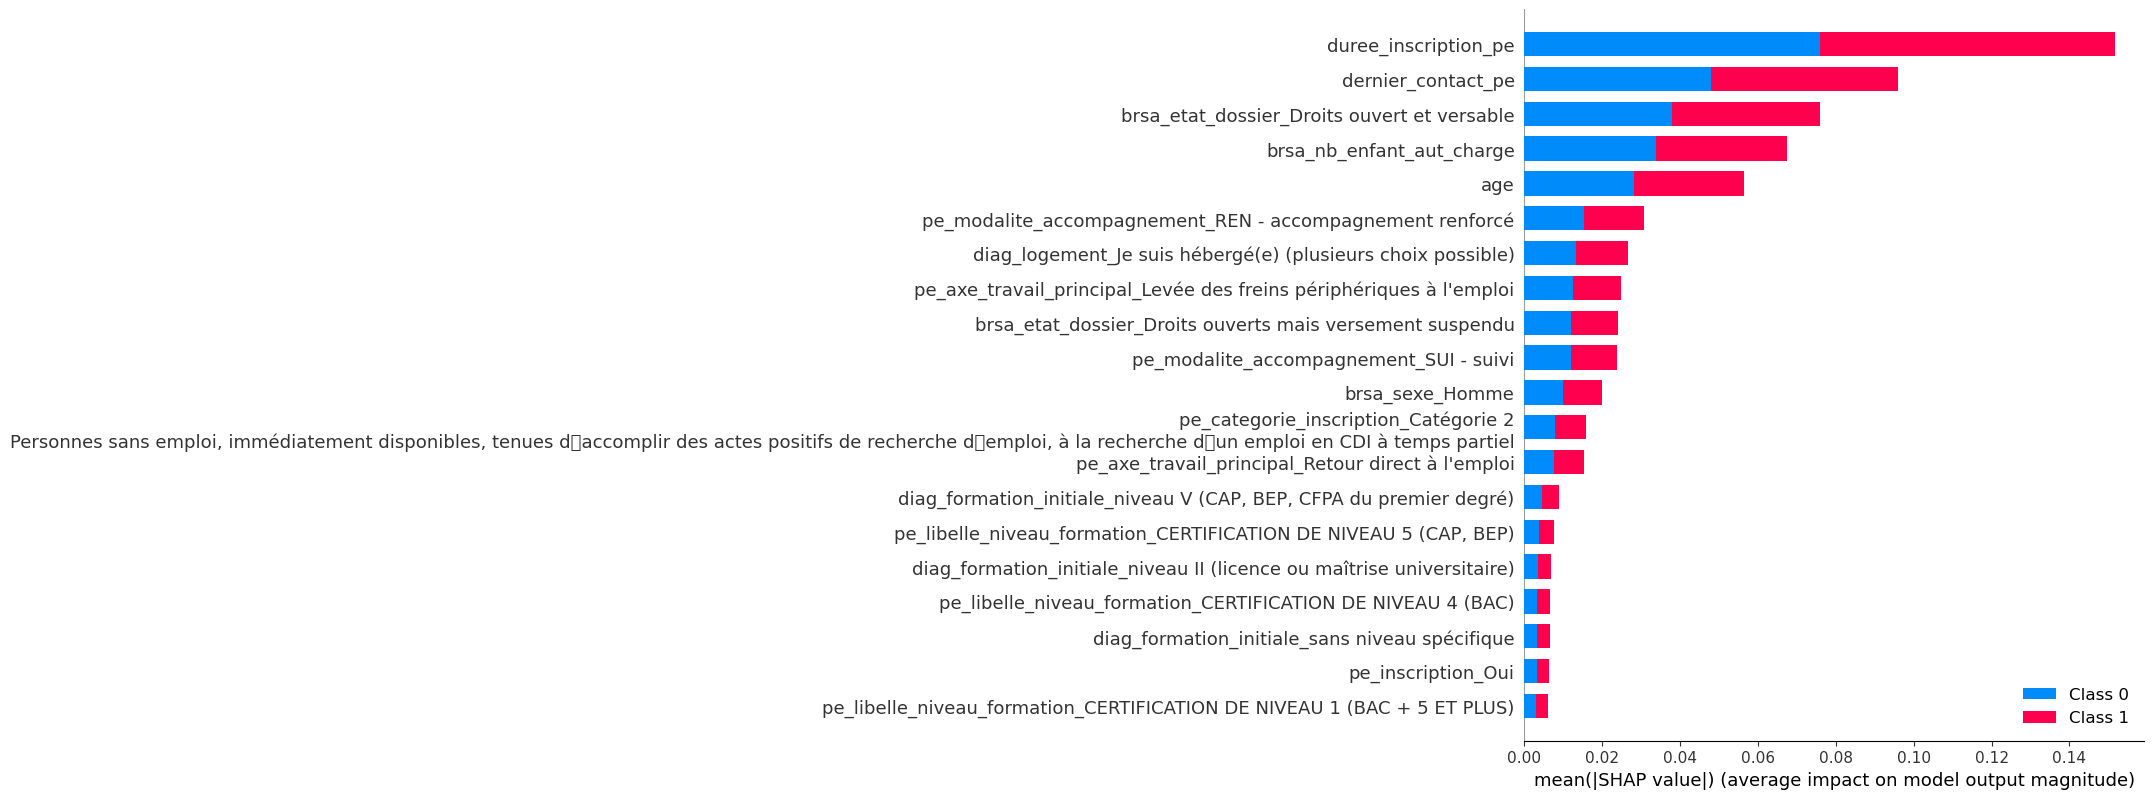

In [12]:
import shap

# Initialize your explainer
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
explain_shap = explainer(X_dev)
# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [13]:
vect = np.mean(np.abs(shap_values[1]), axis=0) 
I_c_minmax = (vect - np.min(vect)) / (np.max(vect) - np.min(vect))
sum_I_c_minmax = np.sum(I_c_minmax)
I_c_normalized = I_c_minmax / sum_I_c_minmax

In [14]:
vect

array([2.81792280e-02, 3.36758381e-02, 4.80130366e-02, 7.58392792e-02,
       9.96332133e-03, 5.87951691e-05, 1.20794707e-05, 0.00000000e+00,
       1.39869643e-05, 3.80081513e-02, 1.20010533e-02, 0.00000000e+00,
       0.00000000e+00, 6.80560919e-04, 3.63571182e-05, 2.15771879e-03,
       1.43091095e-03, 0.00000000e+00, 7.51900922e-06, 4.60988248e-04,
       0.00000000e+00, 0.00000000e+00, 2.38543781e-03, 3.41675107e-03,
       5.86734732e-04, 2.85095561e-03, 4.37799887e-03, 6.04986287e-04,
       0.00000000e+00, 3.26839934e-03, 4.39766762e-04, 1.21880526e-04,
       1.45562426e-04, 1.32406415e-02, 0.00000000e+00, 1.17583580e-03,
       2.38552287e-05, 2.42307124e-04, 1.49336311e-03, 3.01178060e-03,
       5.42291648e-04, 4.51368850e-04, 3.31250722e-03, 3.74330245e-03,
       5.13229597e-06, 3.33247535e-04, 3.18072523e-03, 6.65391203e-04,
       1.24495961e-02, 7.69340381e-03, 3.84333735e-04, 1.00431949e-04,
       1.00153017e-03, 7.89231389e-03, 3.35279011e-04, 3.50694454e-05,
      

In [15]:
I_c_normalized

array([7.83022951e-02, 9.35758572e-02, 1.33414974e-01, 2.10736420e-01,
       2.76853194e-02, 1.63375543e-04, 3.35655143e-05, 0.00000000e+00,
       3.88659123e-05, 1.05614160e-01, 3.33476140e-02, 0.00000000e+00,
       0.00000000e+00, 1.89109091e-03, 1.01026394e-04, 5.99570485e-03,
       3.97610649e-03, 0.00000000e+00, 2.08932509e-05, 1.28095908e-03,
       0.00000000e+00, 0.00000000e+00, 6.62847314e-03, 9.49420797e-03,
       1.63037384e-03, 7.92201857e-03, 1.21652502e-02, 1.68108987e-03,
       0.00000000e+00, 9.08197946e-03, 1.22199043e-03, 3.38672335e-04,
       4.04477797e-04, 3.67920873e-02, 0.00000000e+00, 3.26732309e-03,
       6.62870949e-05, 6.73304605e-04, 4.14964380e-03, 8.36890683e-03,
       1.50687878e-03, 1.25422943e-03, 9.20454309e-03, 1.04016041e-02,
       1.42612336e-05, 9.26002900e-04, 8.83835732e-03, 1.84893846e-03,
       3.45939906e-02, 2.13778453e-02, 1.06795735e-03, 2.79072660e-04,
       2.78297584e-03, 2.19305615e-02, 9.31647810e-04, 9.74483071e-05,
      

In [16]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Obtenir les indices de toutes les instances de cette classe
    class_indices = np.where(y_dev == cls)[0]
    # Sélectionner aléatoirement un indice parmi ces indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 609, 1: 1109}


In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


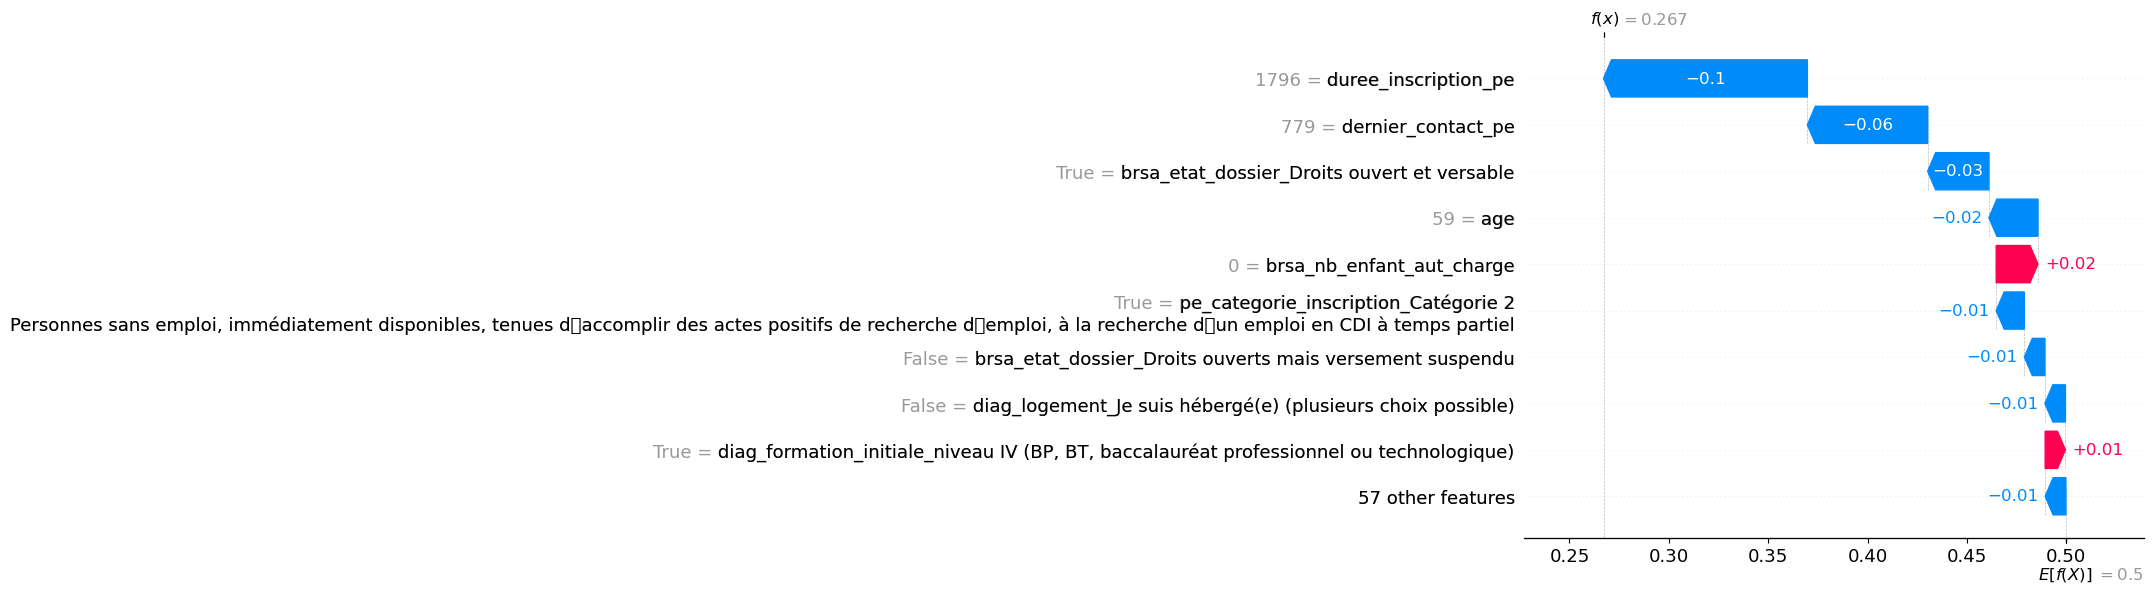

In [18]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

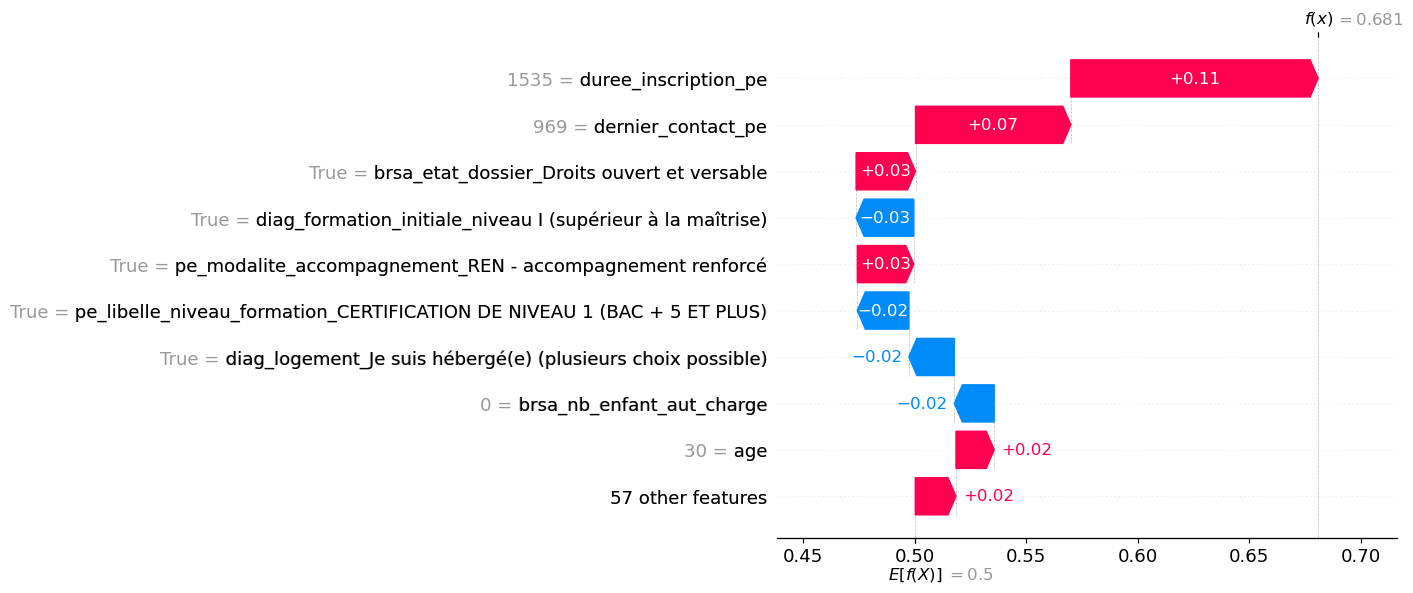

In [20]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))